# Analisis Antrean Drive-Thru dengan Model Lotka–Volterra

Notebook ini menganalisis antrean drive-thru menggunakan pendekatan predator–prey.

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error


## Load Dataset

In [11]:


data = pd.read_csv("queue_data.csv")

# Hapus baris dengan nilai kosong
data = data.dropna(subset=['queue_length', 'wait_time'])

# Ganti wait_time <= 0 agar tidak infinite
data = data[data['wait_time'] > 0]

data = data.reset_index(drop=True)

print("Jumlah data setelah cleaning:", len(data))




Jumlah data setelah cleaning: 547


## Preprocessing Data

In [ ]:
#TIME INDEX DISKRIT 
t = np.arange(len(data))
x_data = data['queue_length'].values



## Estimasi Kapasitas Layanan

In [ ]:

#ESTIMASI KAPASITAS LAYANAN 
service_rate = 1 / data['wait_time'].values
service_rate = np.nan_to_num(service_rate, nan=0.0, posinf=0.0)

# Normalisasi
service_rate = service_rate / np.max(service_rate) * 10
y_data = service_rate


## Visualisasi Data Mentah

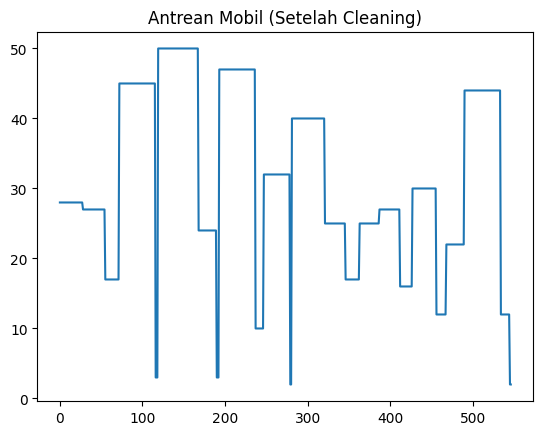

In [14]:

#4️⃣ VISUALISASI CEK DATA
plt.figure()
plt.plot(t, x_data)
plt.title("Antrean Mobil (Setelah Cleaning)")
plt.show()


## Model Lotka–Volterra

In [8]:

def lotka_volterra(state, t, alpha, beta, delta, gamma):
    x, y = state
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]


## Simulasi dan Tuning Parameter

In [17]:
#KONDISI AWAL
x0 = x_data[0]
y0 = max(y_data[0], 0.1)  # cegah y0 = 0

#LOSS FUNCTION 
def mse_loss(params):
    a, b, d, g = params
    
    sol = odeint(lotka_volterra, [x0, y0], t, args=(a, b, d, g))
    x_pred = sol[:, 0]
    
    # Filter NaN / Inf
    if np.any(np.isnan(x_pred)) or np.any(np.isinf(x_pred)):
        return np.inf
    
    return mean_squared_error(x_data, x_pred)

#GRID SEARCH 
best_loss = np.inf
best_param = None

for a in np.linspace(0.3, 0.9, 5):
    for b in np.linspace(0.005, 0.03, 5):
        for d in np.linspace(0.005, 0.02, 5):
            for g in np.linspace(0.2, 0.8, 5):
                loss = mse_loss([a, b, d, g])
                if loss < best_loss:
                    best_loss = loss
                    best_param = [a, b, d, g]

print("Best Parameter:", best_param)
print("Best MSE:", best_loss)



C:\Users\user\AppData\Local\Temp\ipykernel_26444\266111970.py:9: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, [x0, y0], t, args=(a, b, d, g))


Best Parameter: [np.float64(0.3), np.float64(0.03), np.float64(0.02), np.float64(0.2)]
Best MSE: 991.5549200718739


## Visualisasi Akhir

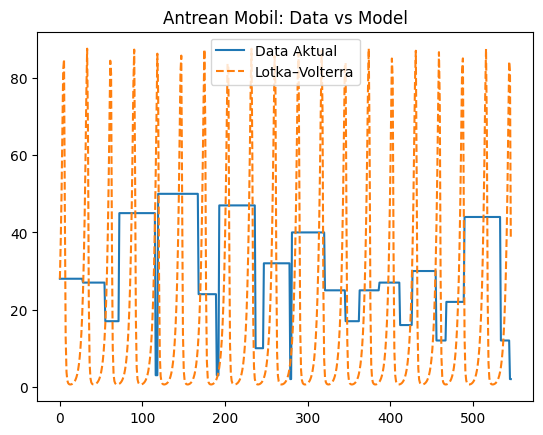

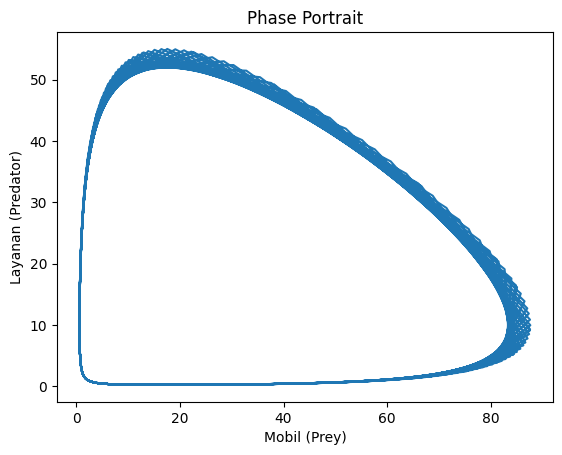

In [16]:

#SIMULASI FINAL
alpha_b, beta_b, delta_b, gamma_b = best_param

solution_best = odeint(
    lotka_volterra,
    [x0, y0],
    t,
    args=(alpha_b, beta_b, delta_b, gamma_b)
)

#VISUALISASI AKHIR
#Time Series
plt.figure()
plt.plot(t, x_data, label="Data Aktual")
plt.plot(t, solution_best[:,0], '--', label="Lotka–Volterra")
plt.legend()
plt.title("Antrean Mobil: Data vs Model")
plt.show()

#Phase Portrait
plt.figure()
plt.plot(solution_best[:,0], solution_best[:,1])
plt.xlabel("Mobil (Prey)")
plt.ylabel("Layanan (Predator)")
plt.title("Phase Portrait")
plt.show()

